In [1]:
%cd /Midgard/home/amirme/an_explanation_model

/Midgard/home/amirme/an_explanation_model


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    load_experiment_inconsistency,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_6_1 import (
    save_metadata_dir,
    dataset_dir,
    input_shape,
    save_output_dir,
)

os.makedirs(save_output_dir, exist_ok=True)
from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

2023-11-07 14:29:29.554591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:29:34.919766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_metadata = load_experiment_metadata(save_metadata_dir)
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "baseline_mask_type",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'image_path', 'input_shape', 'num_classes',
       'seed', 'batch_size', 'max_batches', 'min_change',
       'metadata_file_path'],
      dtype='object')
(972, 23)


In [108]:
def preprocess_masks(masks, preprocesses):
    for preprocess in preprocesses:
        masks = preprocess(masks)
    return masks


# def apply_frequency_generic(data, func, perprocess):
#     init_val = []

#     for id, row in data.iterrows():
#         temp_grad = np.load(row["grad_mask"])
#         temp_grad = preprocess_masks(temp_grad, preprocesses=perprocess)
#         temp_grad = func(temp_grad)
#         print(temp_grad.shape)
#         init_val.append(temp_grad)

#     return init_val


def _fourier_transform(x):
    assert x.shape == (1, 224, 224) or x.shape == (224, 224), x.shape
    x = x.squeeze()
    return np.fft.fftshift(np.fft.fft2(x))


def _inverse_fourier_transform(x):
    return np.abs(np.fft.ifft2(np.fft.ifftshift(x)))


def cartesian_to_polar(x):
    assert x.shape == (1, 224, 224)
    return 

In [39]:
# original_image, label, image_path = query_imagenet(image_index=43)

2023-11-07 14:56:02.259754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-07 14:56:02.259828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: gondor
2023-11-07 14:56:02.259842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: gondor
2023-11-07 14:56:02.259947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.89.2
2023-11-07 14:56:02.259983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.89.2
2023-11-07 14:56:02.259992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.89.2
2023-11-07 14:56:02.761928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (

In [128]:
image_indices = [43]
explanations_temp = project_metadata.loc[
    ("vanilla_grad_mask", "meanx2", image_indices, "gaussian", slice(0,80,10)), "data_path"
]
explanations_temp = explanations_temp.droplevel(
    ["stream_name", "stream_statistic", "baseline_mask_type"]
)
explanations_temp.name = "grad_mask"
explanations_temp.sort_index(inplace=True)
explanations_temp = explanations_temp.apply(np.load)
explanations_temp = explanations_temp.apply(sum_channels)
explanations_temp = explanations_temp.apply(lambda x:np.squeeze(x,axis=-1))
explanations_temp = explanations_temp.apply(lambda x:1.0*(x<np.percentile(x,50)))
explanations_fourier = explanations_temp.apply(_fourier_transform)
explanations_fourier = explanations_fourier.apply(cartesian_to_polar)

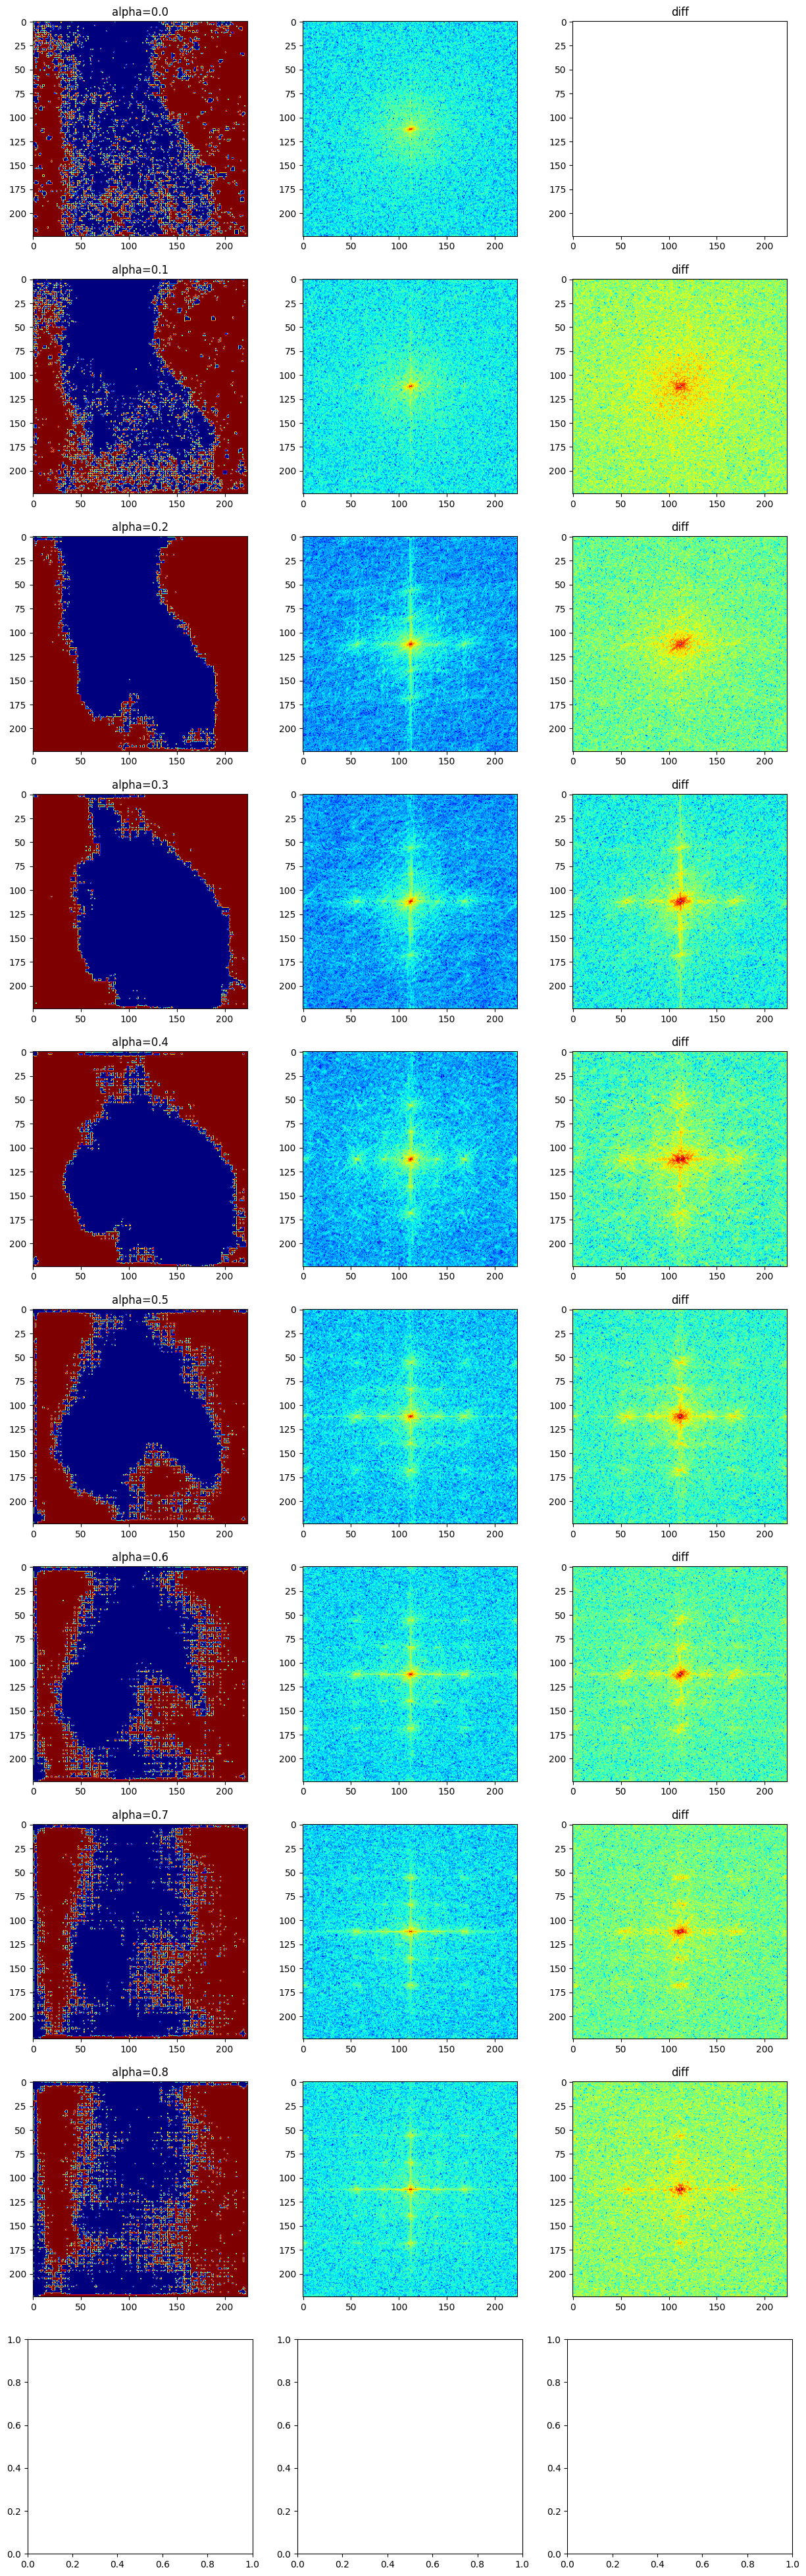

In [129]:
n_rows = 10
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
frequencies = explanations_temp.index.get_level_values("alpha_mask_value")
for ax, explanation, fourier,fourier_diff, freq in zip(axes, explanations_temp, explanations_fourier,explanations_fourier_diff, frequencies):
    fourier = np.abs(fourier)
    fourier = np.log(fourier + 1)
    fourier = minmax_normalize(fourier)

    fourier_diff = np.abs(fourier_diff)
    fourier_diff = np.log(fourier_diff + 1)
    fourier_diff = minmax_normalize(fourier_diff)

    ax[0].imshow(explanation, **imshow_args)
    ax[1].imshow(fourier, **imshow_args)
    ax[0].set_title(f"alpha={freq}")
    ax[2].imshow(fourier_diff, **imshow_args)
    ax[2].set_title(f"diff")

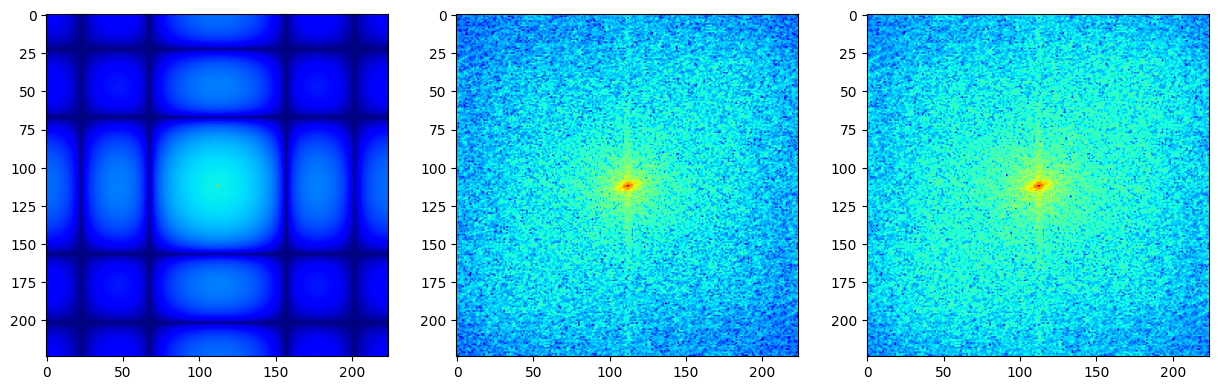

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

pixel_deletion_mask = np.ones_like(original_image)
pixel_deletion_mask[0, 50:55, 50:55, :] = 0
image_masked = original_image * pixel_deletion_mask
pixel_deletion_mask = sum_channels(pixel_deletion_mask).squeeze()
temp_original = sum_channels(original_image).squeeze()
image_masked = sum_channels(image_masked).squeeze()

f_original = _fourier_transform(pixel_deletion_mask)
f_original = np.log(np.abs(f_original) + 1)
axes[0].imshow(f_original, **imshow_args)

f_original = _fourier_transform(temp_original)
f_original = np.log(np.abs(f_original) + 1)
axes[1].imshow(f_original, **imshow_args)

f_original = _fourier_transform(image_masked)
f_original = np.log(np.abs(f_original) + 1)
axes[2].imshow(f_original, **imshow_args)